In this notebook I will plotting my results to replicating my colleague Harshil Kamdar's work with Random Forests. His code and data are both available [here](https://github.com/ProfessorBrunner/ml4cosmosims).

The data for this project are loaded and pre-processed identically as done in his notebook under "results." If you are interested in more details, I suggest you look there. 

In [16]:
import numpy as np
import sys
import os
import cPickle as pickle
import gzip
import pylearn2

from pylearn2.utils import serial
from theano import tensor as T
from theano import function

os.environ['PYLEARN2_DATA_PATH'] = '/home/mclaughlin6464/GitRepos/pylearn2/data'

In [17]:
#This function is from predict_csv in mlp. However, I'm tweaking it to return the prediction!
def predict(model_path, x, predictionType="regression", outputType="float",
            headers=False, first_col_label=False, delimiter=","):
    """
    Predict from a pkl file.

    Parameters
    ----------
    modelFilename : str
        The file name of the model file.
    testFilename : str
        The file name of the file to test/predict.
    outputFilename : str
        The file name of the output file.
    predictionType : str, optional
        Type of prediction (classification/regression).
    outputType : str, optional
        Type of predicted variable (int/float).
    headers : bool, optional
        Indicates whether the first row in the input file is feature labels
    first_col_label : bool, optional
        Indicates whether the first column in the input file is row labels (e.g. row numbers)
    """

    print("loading model...")

    try:
        model = serial.load(model_path)
    except Exception as e:
        print("error loading {}:".format(model_path))
        print(e)
        return False

    print("setting up symbolic expressions...")

    X = model.get_input_space().make_theano_batch()
    Y = model.fprop(X)

    if predictionType == "classification":
        Y = T.argmax(Y, axis=1)

    f = function([X], Y, allow_input_downcast=True)

    print("loading data and predicting...")

    # x is a numpy array
    # x = pickle.load(open(test_path, 'rb'))

    if first_col_label:
        x = x[:,1:]

    y = f(x)
    return y

In [18]:
true_features, true_values = pickle.load(gzip.open(os.environ['PYLEARN2_DATA_PATH']+'/milleniumSAMs/'+'milliTest.pickle.gz', 'rb'))
minMaxValues = pickle.load(open(os.environ['PYLEARN2_DATA_PATH']+'/milleniumSAMs/'+'minMaxVals.pkl'))

path = os.path.join(pylearn2.__path__[0], 'myStuff', 'milli_sam_1_best.pkl' )
predictions = predict(path, true_features)

loading model...
setting up symbolic expressions...
loading data and predicting...


In [19]:
#un-normalize the data
for i in xrange(201):
    minval, maxval = minMaxValues[i]
    if i == 194:#not used
        continue
    elif i<193:#features
        true_features[:,i] = true_features[:,i]*(maxval-minval)+minval
    else:#labels/values
        j = i-195
        true_values[:,j] = true_values[:,j]*(maxval-minval)+minval
        predictions[:,j] = predictions[:,j]*(maxval-minval)+minval

The following data were obtained by training a neural net (a modified variation of PDNN for regression) on a random 60% of the training data and validated over an additional 20%. There were 20 hidden units. It was trained for 100 learning epochs with a constant learning rate of 0.1, and momentum of 0.5, and an L2 regression coefficent of 0.0001. 

In [20]:
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
labels = ['Stellar Mass', 'Cold Gas Mass', 'Bulge Mass', 'Hot Gas Mass', 'Cooling Radius', 'Blk Hle Mass']

for i in xrange(6):
    R2 = r2_score(true_values[:,i], predictions[:,i])
    pearR, pvalue2 = pearsonr(true_values[:,i], predictions[:,i])
    print '%s:\tR^2:%.3f\tPearson R:%.3f'%(labels[i],R2, pearR)


Stellar Mass:	R^2:0.771	Pearson R:0.882
Cold Gas Mass:	R^2:0.386	Pearson R:0.623
Bulge Mass:	R^2:0.781	Pearson R:0.885
Hot Gas Mass:	R^2:0.986	Pearson R:0.994
Cooling Radius:	R^2:0.850	Pearson R:0.922
Blk Hle Mass:	R^2:0.880	Pearson R:0.938


Now, for some plots.

Thank you Harshil, for putting in the Seaborn work so I don't have to.

In [21]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

sns.set_style("white")
sns.set_style("ticks")

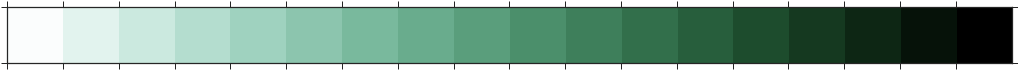

In [22]:
sns.palplot(sns.cubehelix_palette(18, start=2, rot=0.1, dark=0, light=0.99))
cold_cmap = sns.cubehelix_palette(18, start=2, rot=0.1, dark=0, light=0.99, as_cmap=True)

In [23]:
%run 'helper_sam.ipynb'

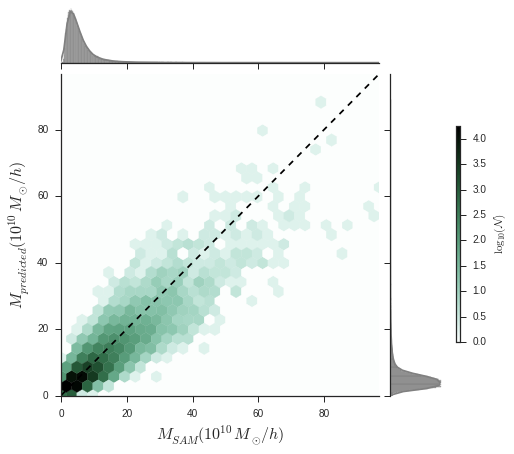

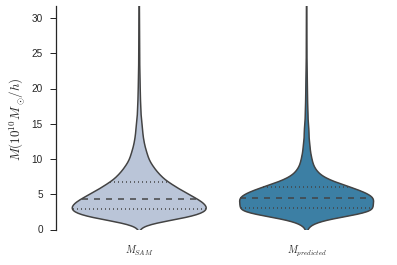

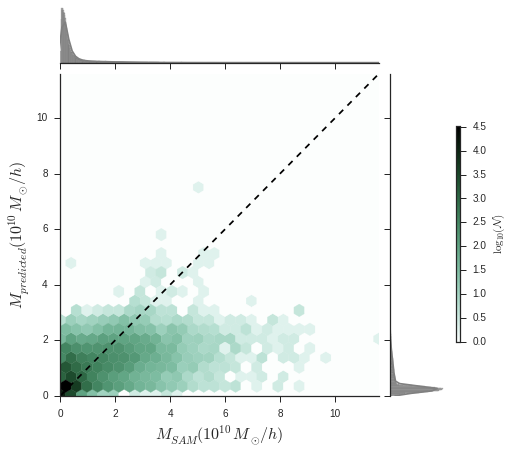

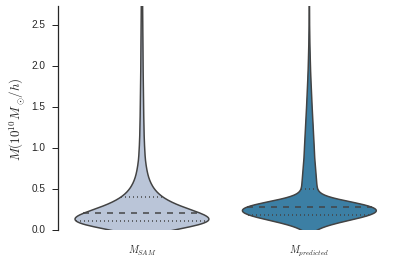

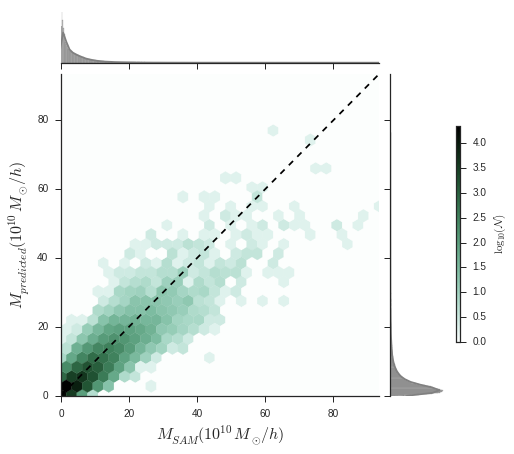

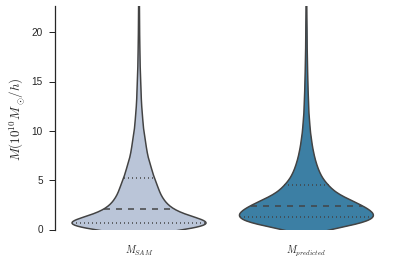

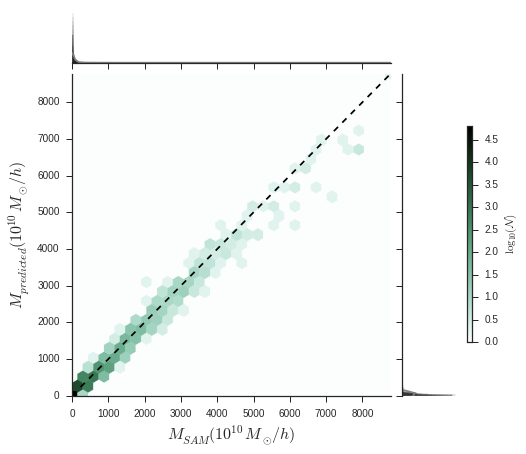

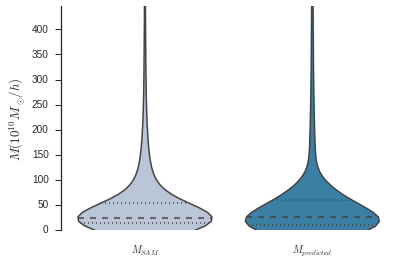

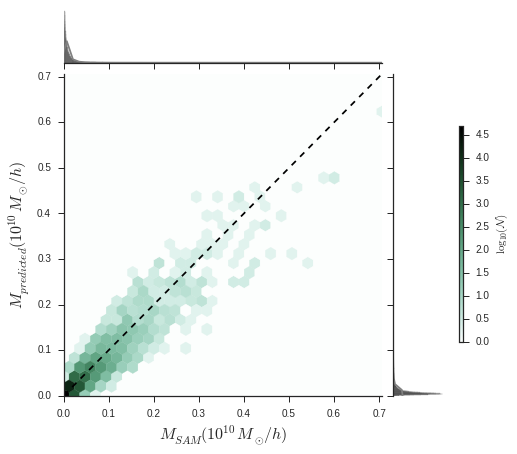

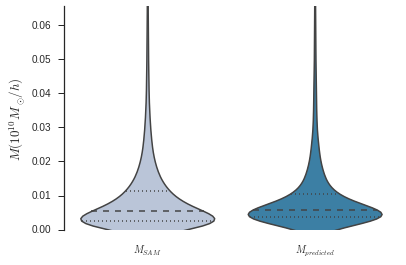

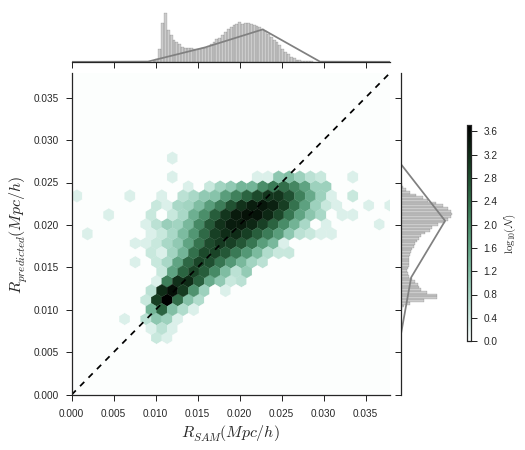

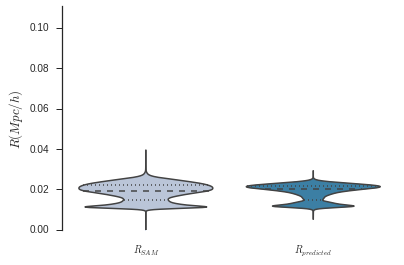

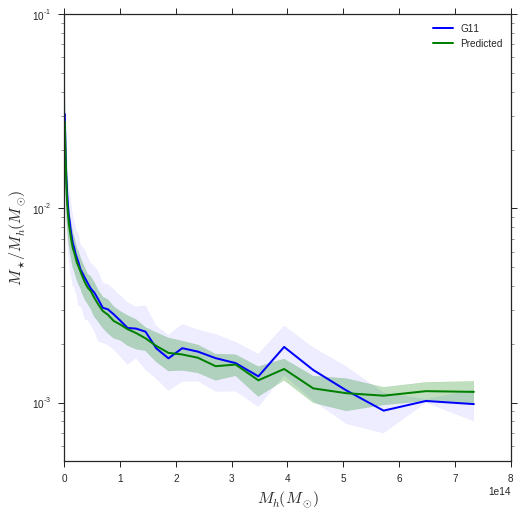

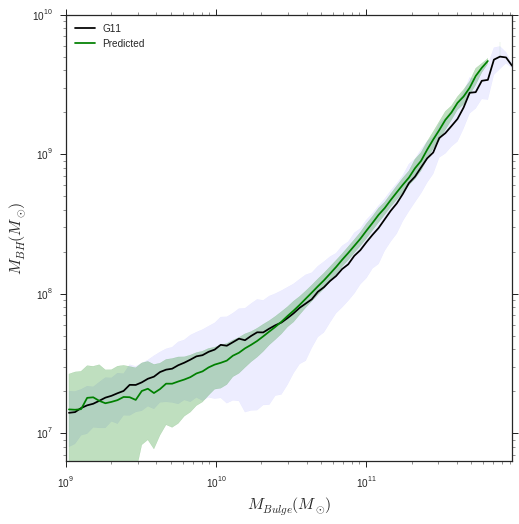

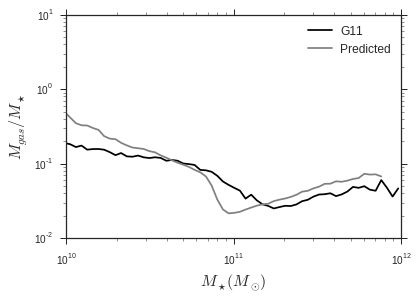

In [25]:
mse_nn = mse(true_values, predictions)
[genplots_M(np.c_[true_values[:,i], predictions[:,i]], mse_nn[i]) for i in [x for x in xrange(0,6) if x != 4]]
genplots_M(np.c_[true_values[:,4], predictions[:,4]], mse_nn[4], plot_type='R') 

#This plot was throwing and error and I couldn't figure out why.
#I won't sweat it for now; can dive in later. 
plot_smhm(true_values[:,0], predictions[:,0], true_features[:,0])
plot_bhbulge(true_values[:,5], predictions[:,5], true_values[:,2], predictions[:,2])
plot_coldgasfrac(true_values[:,1], predictions[:,1], true_values[:,0], predictions[:,0])